# Laptop Price Prediction — Model Training
This notebook trains and evaluates baseline models to predict `Price_euros`.
We will:
- Load the cleaned dataset.
- Split into train/test sets.
- Optionally scale numeric features.
- Train a baseline Linear Regression.
- Train a Random Forest regressor.
- Evaluate with MAE, RMSE and R².
- Visualize predictions and save the best model (for later Streamlit use).

### Step 0 - Imports Necessary Libraries (Imports used throughout the notebook.)

In [16]:
# Step 0 - imports
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

sns.set(style="whitegrid")
RANDOM_STATE = 1  
# We will use random_state=1 and test_size=0.2 (20%) as our group's values.

# Ensure output folders exist
os.makedirs("../models", exist_ok=True)
os.makedirs("../reports/figures", exist_ok=True)

### Step 1 - Load Dataset (Load the processed CSV saved from data cleaning.)

In [17]:
data = pd.read_csv("../data/processed/laptops_cleanned.csv")
print("Shape:", data.shape)
display(data.head())
print("\nMissing values per column:\n", data.isnull().sum())

Shape: (1303, 16)


,Company,TypeName,Inches,Cpu,Ram,Gpu,OpSys,Weight,Price_euros,SSD,HDD,Hybrid,Flash_Storage,Touchscreen,X_resolution,Y_resolution
0,Apple,Ultrabook,13.3,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,128,0,0,0,0,2560,1600
1,Apple,Ultrabook,13.3,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,898.94,0,0,0,128,0,1440,900
2,HP,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,575.00,256,0,0,0,0,1920,1080
3,Apple,Ultrabook,15.4,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,2537.45,512,0,0,0,0,2880,1800
4,Apple,Ultrabook,13.3,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,256,0,0,0,0,2560,1600



Missing values per column:
 Company          0
TypeName         0
Inches           0
Cpu              0
Ram              0
Gpu              0
OpSys            0
Weight           0
Price_euros      0
SSD              0
HDD              0
Hybrid           0
Flash_Storage    0
Touchscreen      0
X_resolution     0
Y_resolution     0
dtype: int64


### Step 2 - Definition
We will define features (X) and target (y) before separating predictors and target variable.

In [18]:
if "Price_euros" not in data.columns:
    raise KeyError("Target column 'Price_euros' not found in dataset.")

# Features (independent variables)
X = data.drop("Price_euros", axis=1)

# Target (dependent variable)
y = data["Price_euros"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1303, 15)
y shape: (1303,)


## Step 3 - Identify Categorical and Numerical Features

#### We will identify categorical and numerical features for preprocessing.

In [19]:
# Identify categorical and numerical columns
categorical_cols = ["Company", "TypeName", "Cpu", "Gpu", "OpSys"]
numeric_cols = ["Inches", "Ram", "Weight", "SSD", "HDD", "Hybrid",
                "Flash_Storage", "Touchscreen", "X_resolution", "Y_resolution"]

### Step 4 - Preprocessing
#### preprocessing categorical features with 

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing: OneHotEncode categorical features

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

### Step 6: Create pipeline with preprocessing + model

In [21]:
from sklearn.pipeline import Pipeline
# Build pipeline with preprocessing + Linear Regression

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

### Step 3 — Train / test split
- Reserve 20% for test. 
- Keep random_state for reproducibility.

In [22]:
X_train, X_test, y_train, y_test = split(X, y,test_size=0.2, random_state=RANDOM_STATE)
print("X_train:", X_train.shape, '\n' "X_test:", X_test.shape)

X_train: (1042, 15) 
X_test: (261, 15)


###  Step 7: Train the model

In [23]:
# Train the model
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Step 10: Make predictions on the test set


In [24]:
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

print(f'Prediction on training set: {y_train_pred[:10]}')
print(f'Actual Training data: {y_train[:10].values}')

print('Prediction on test set:', y_pred[:10])
print('Actual Test data:', y_test[:10].values)

Prediction on training set: [1780.15134771  735.20289488 1333.0801787  2421.8987367  1223.15649352
 1074.14738901 1875.25660514 5107.8536572  3965.19461252 1320.57287065]
Actual Training data: [1775.  665. 1579. 2799. 1099. 1082. 2349. 5499. 3975.  989.]
Prediction on test set: [ 366.36857763  734.81305692 1458.63031965 1008.34222248 2104.82610301
  814.93192044 1492.00532378  770.64270118   92.94865193 1230.12060813]
Actual Test data: [ 450.    729.   1079.   1049.26 1899.   1018.    752.    649.    289.
 1962.99]


In [25]:
print(" Model training complete!")
print("Training Score (R²):", model.score(X_train, y_train))
print("Testing Score (R²):", model.score(X_test, y_test))

 Model training complete!
Training Score (R²): 0.8889397857711226
Testing Score (R²): 0.8318355158313999


### Step 11: Evaluate predictions

In [26]:

print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R² Score: 0.8318355158313999
MAE: 188.63265776056738
MSE: 82697.01031633044
RMSE: 287.5708787696182


### Step 10 — Visualize predictions vs actual
- Plot actual vs predicted and a 45° line to see fit.

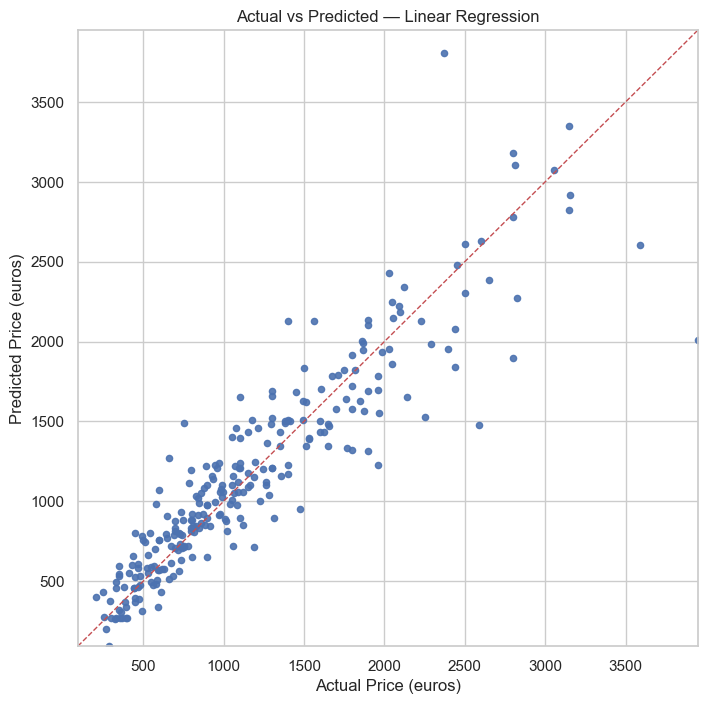

Plot saved to ../reports/figures/actual_vs_predicted_linear_regression.png


In [27]:
# Step 10 - Visualize Linear Regression results only
best_pred = y_pred 

plt.figure(figsize=(8,8))
plt.scatter(y_test, best_pred, alpha=0.9, s=20)
lims = [min(y_test.min(), best_pred.min()), max(y_test.max(), best_pred.max())]
plt.plot(lims, lims, 'r--', linewidth=1)  # identity line
plt.xlabel("Actual Price (euros)")
plt.ylabel("Predicted Price (euros)")
plt.title("Actual vs Predicted — Linear Regression")
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.savefig("../reports/figures/actual_vs_predicted_linear_regression.png", dpi=150)
plt.show()
print("Plot saved to ../reports/figures/actual_vs_predicted_linear_regression.png")

### Step 11 — Save  model for deployment
- Simply save the model file to `../models` for use in Streamlit or inference.

In [28]:
model_path = "../models/laptop_price_model.pkl"

# Save the trained pipeline model
joblib.dump(model, model_path)

print(f"✅ Model saved successfully at {model_path}")

✅ Model saved successfully at ../models/laptop_price_model.pkl
